# Project: Automated Detection of Negative Movie Reviews Using Machine Learning 

### Introduction. 
In this project, we tackled the problem of sentiment analysis by developing a model to classify IMDB movie reviews as positive or negative. The dataset used for this task consists of movie reviews labeled with polarity indicators. Our objective was to build a robust classification model capable of distinguishing between positive and negative reviews. To achieve this, we applied a series of preprocessing steps, including text normalization and tokenization, followed by feature extraction using TF-IDF vectorization. Several machine learning models were trained and evaluated to determine the most effective approach, with the goal of achieving an F1 score above 0.85. This project explores different models, such as Logistic Regression, LightGBM, and RandomForestClassifier, to identify the best-performing model for sentiment classification.


## Initialization

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [6]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [8]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df_reviews.info()
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [10]:
# We check duplicated and missing values
print(df_reviews.duplicated().sum())           # no duplicated rows. 

df_reviews.isna().sum()   #['average_rating'] and ['votes'] columns have 2 missing values each. 

missing_average_rating = df_reviews[df_reviews['average_rating'].isna()].index.tolist()
print("Missing indices in 'average_rating' :", missing_average_rating)
missing_votes = df_reviews[df_reviews['votes'].isna()].index.tolist()
print("Missing indices in 'votes':", missing_votes)

#We remove the rows corresponding to the missing values. (we can )
df_reviews = df_reviews.dropna(subset=['average_rating', 'votes']).reset_index(drop=True)


0
Missing indices in 'average_rating' : [22280, 22281]
Missing indices in 'votes': [22280, 22281]


## EDA

Let's check the number of movies and reviews over years.

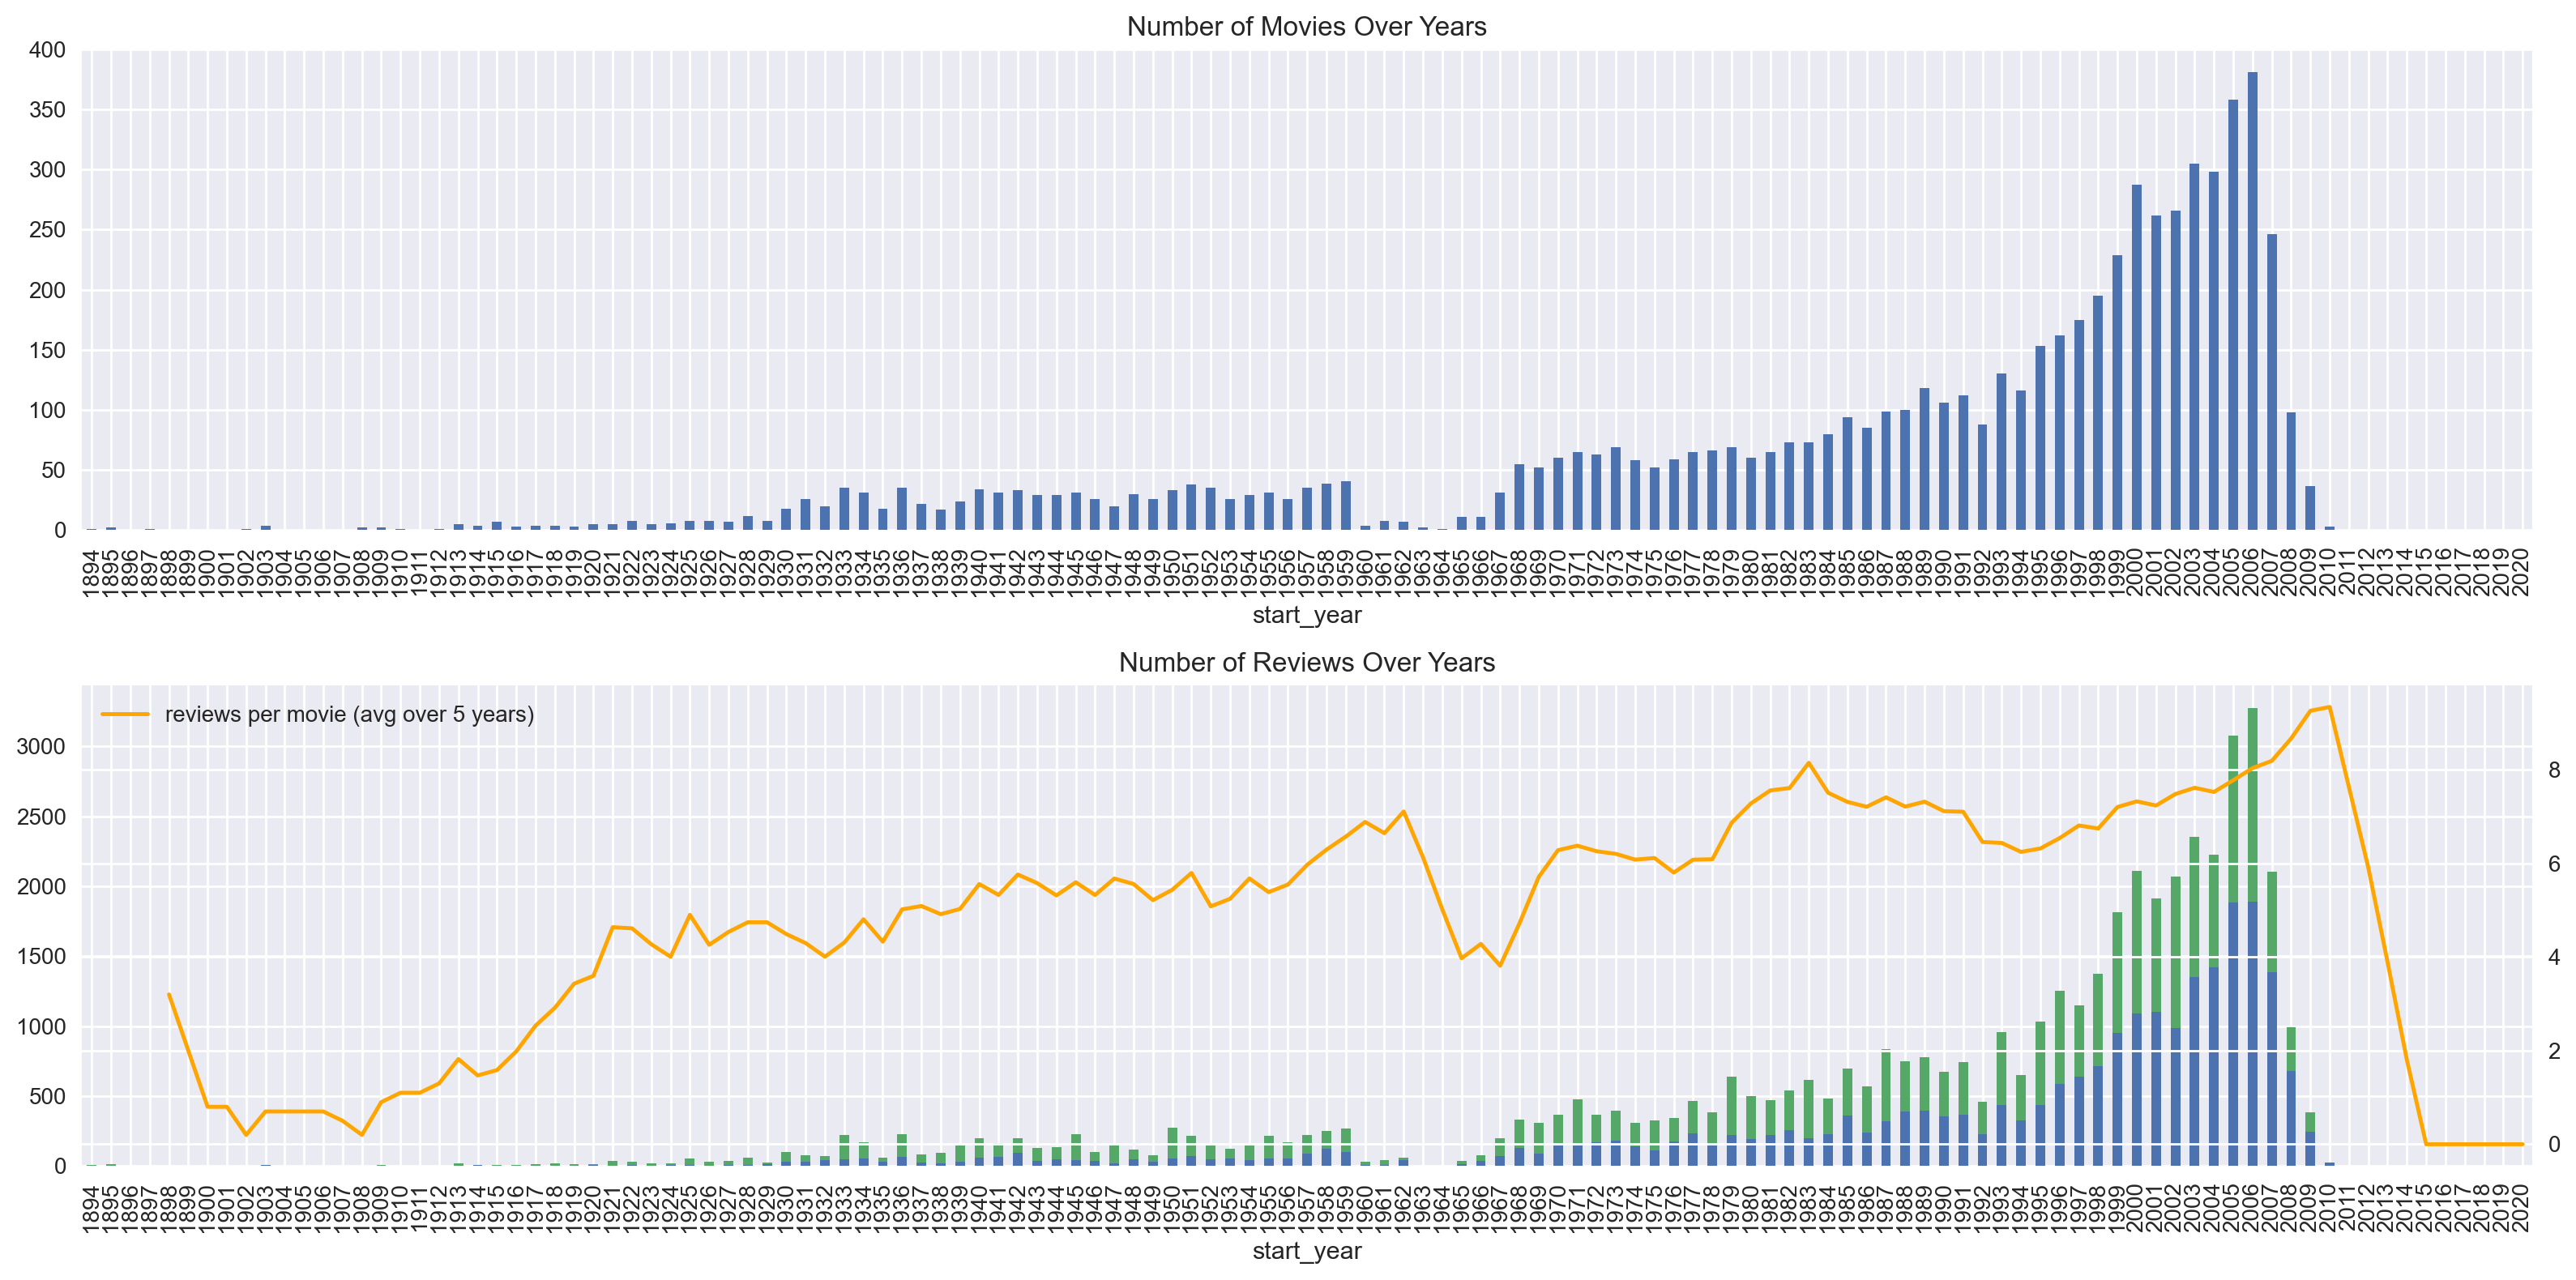

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

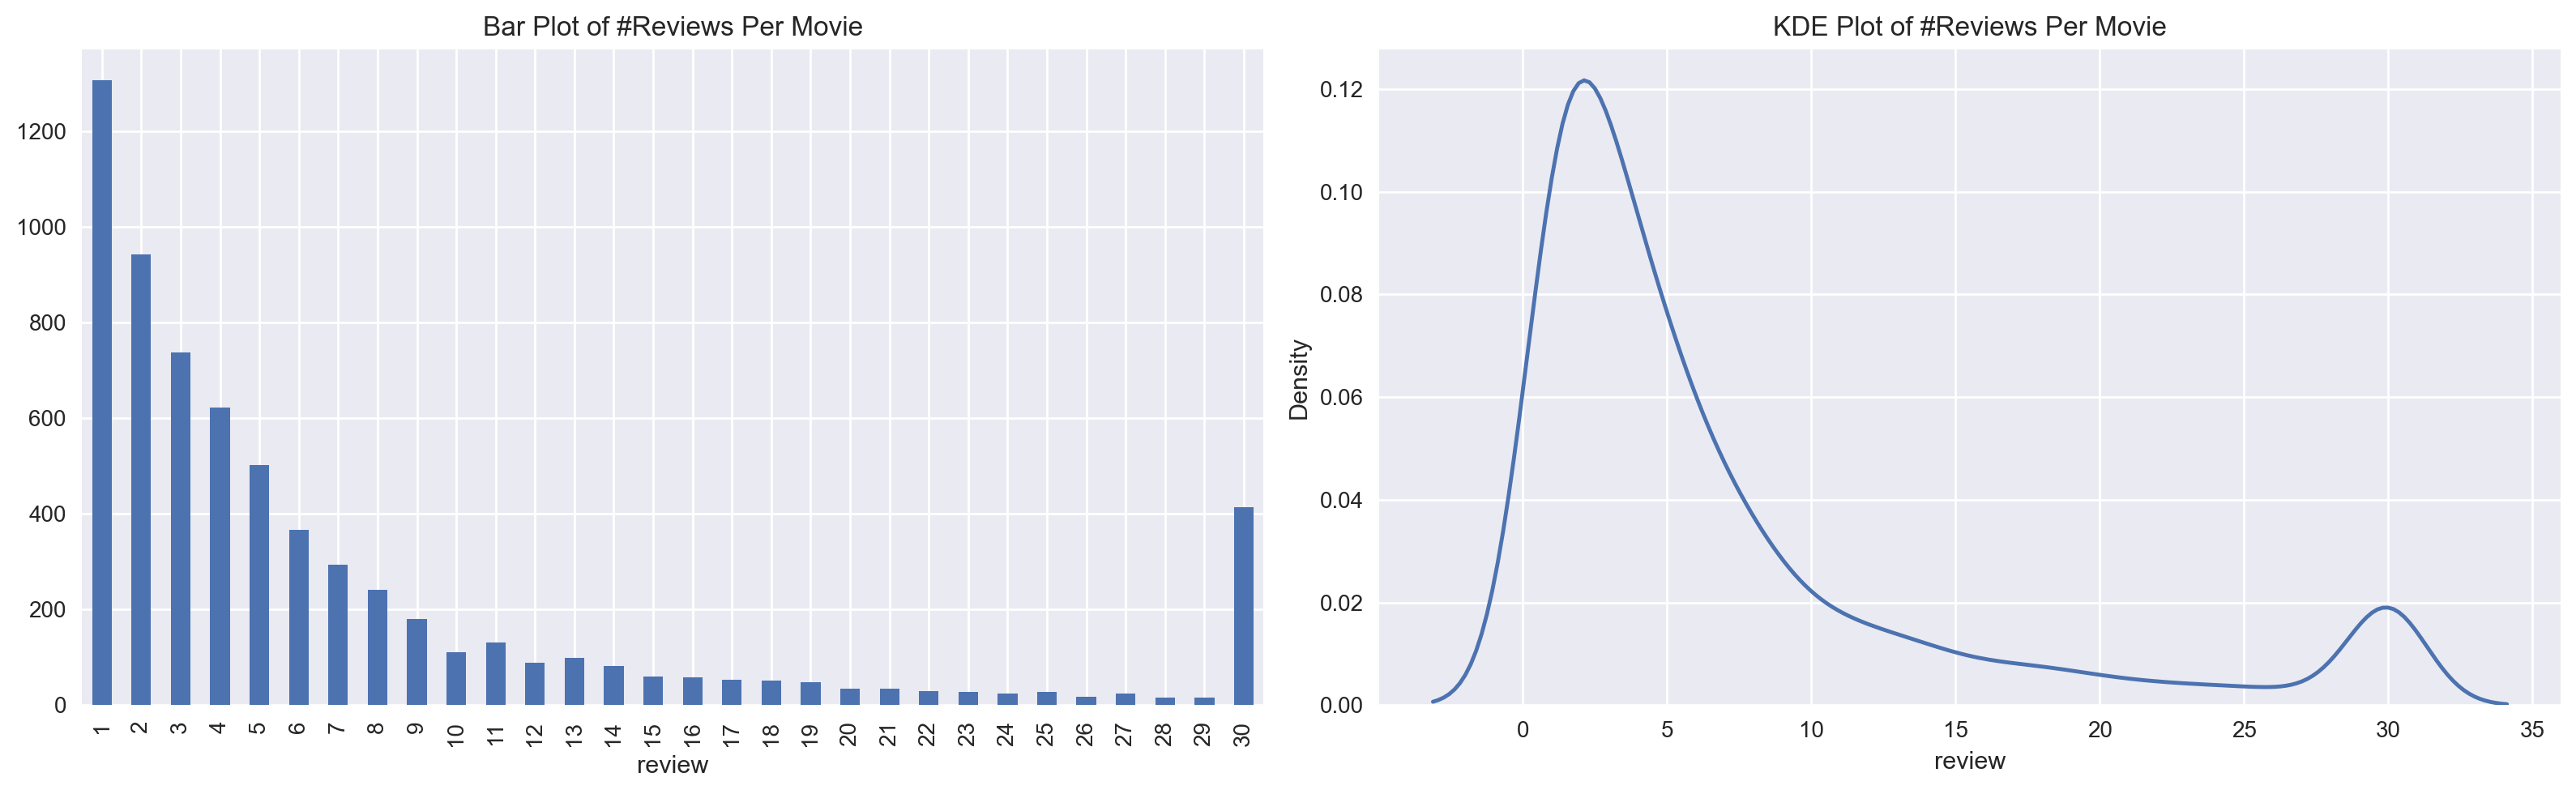

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [16]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

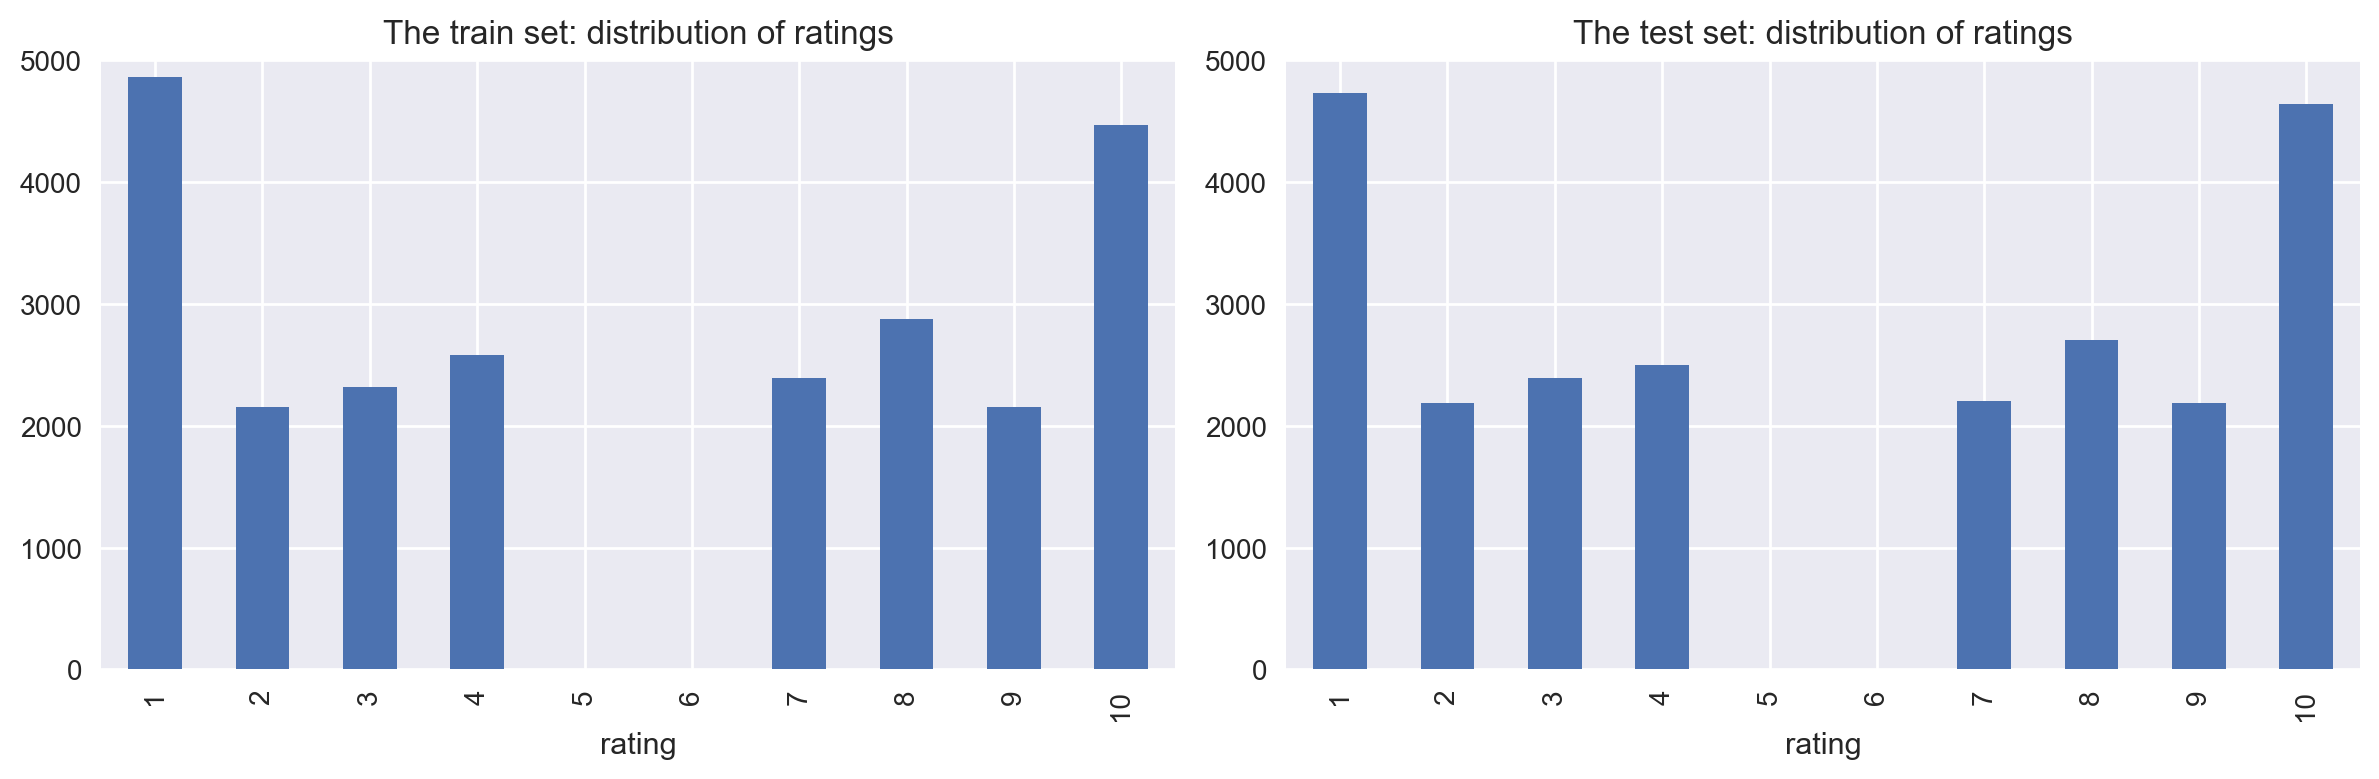

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_1952/2564148758.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_1952/2564148758.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_1952/2564148758.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipyke

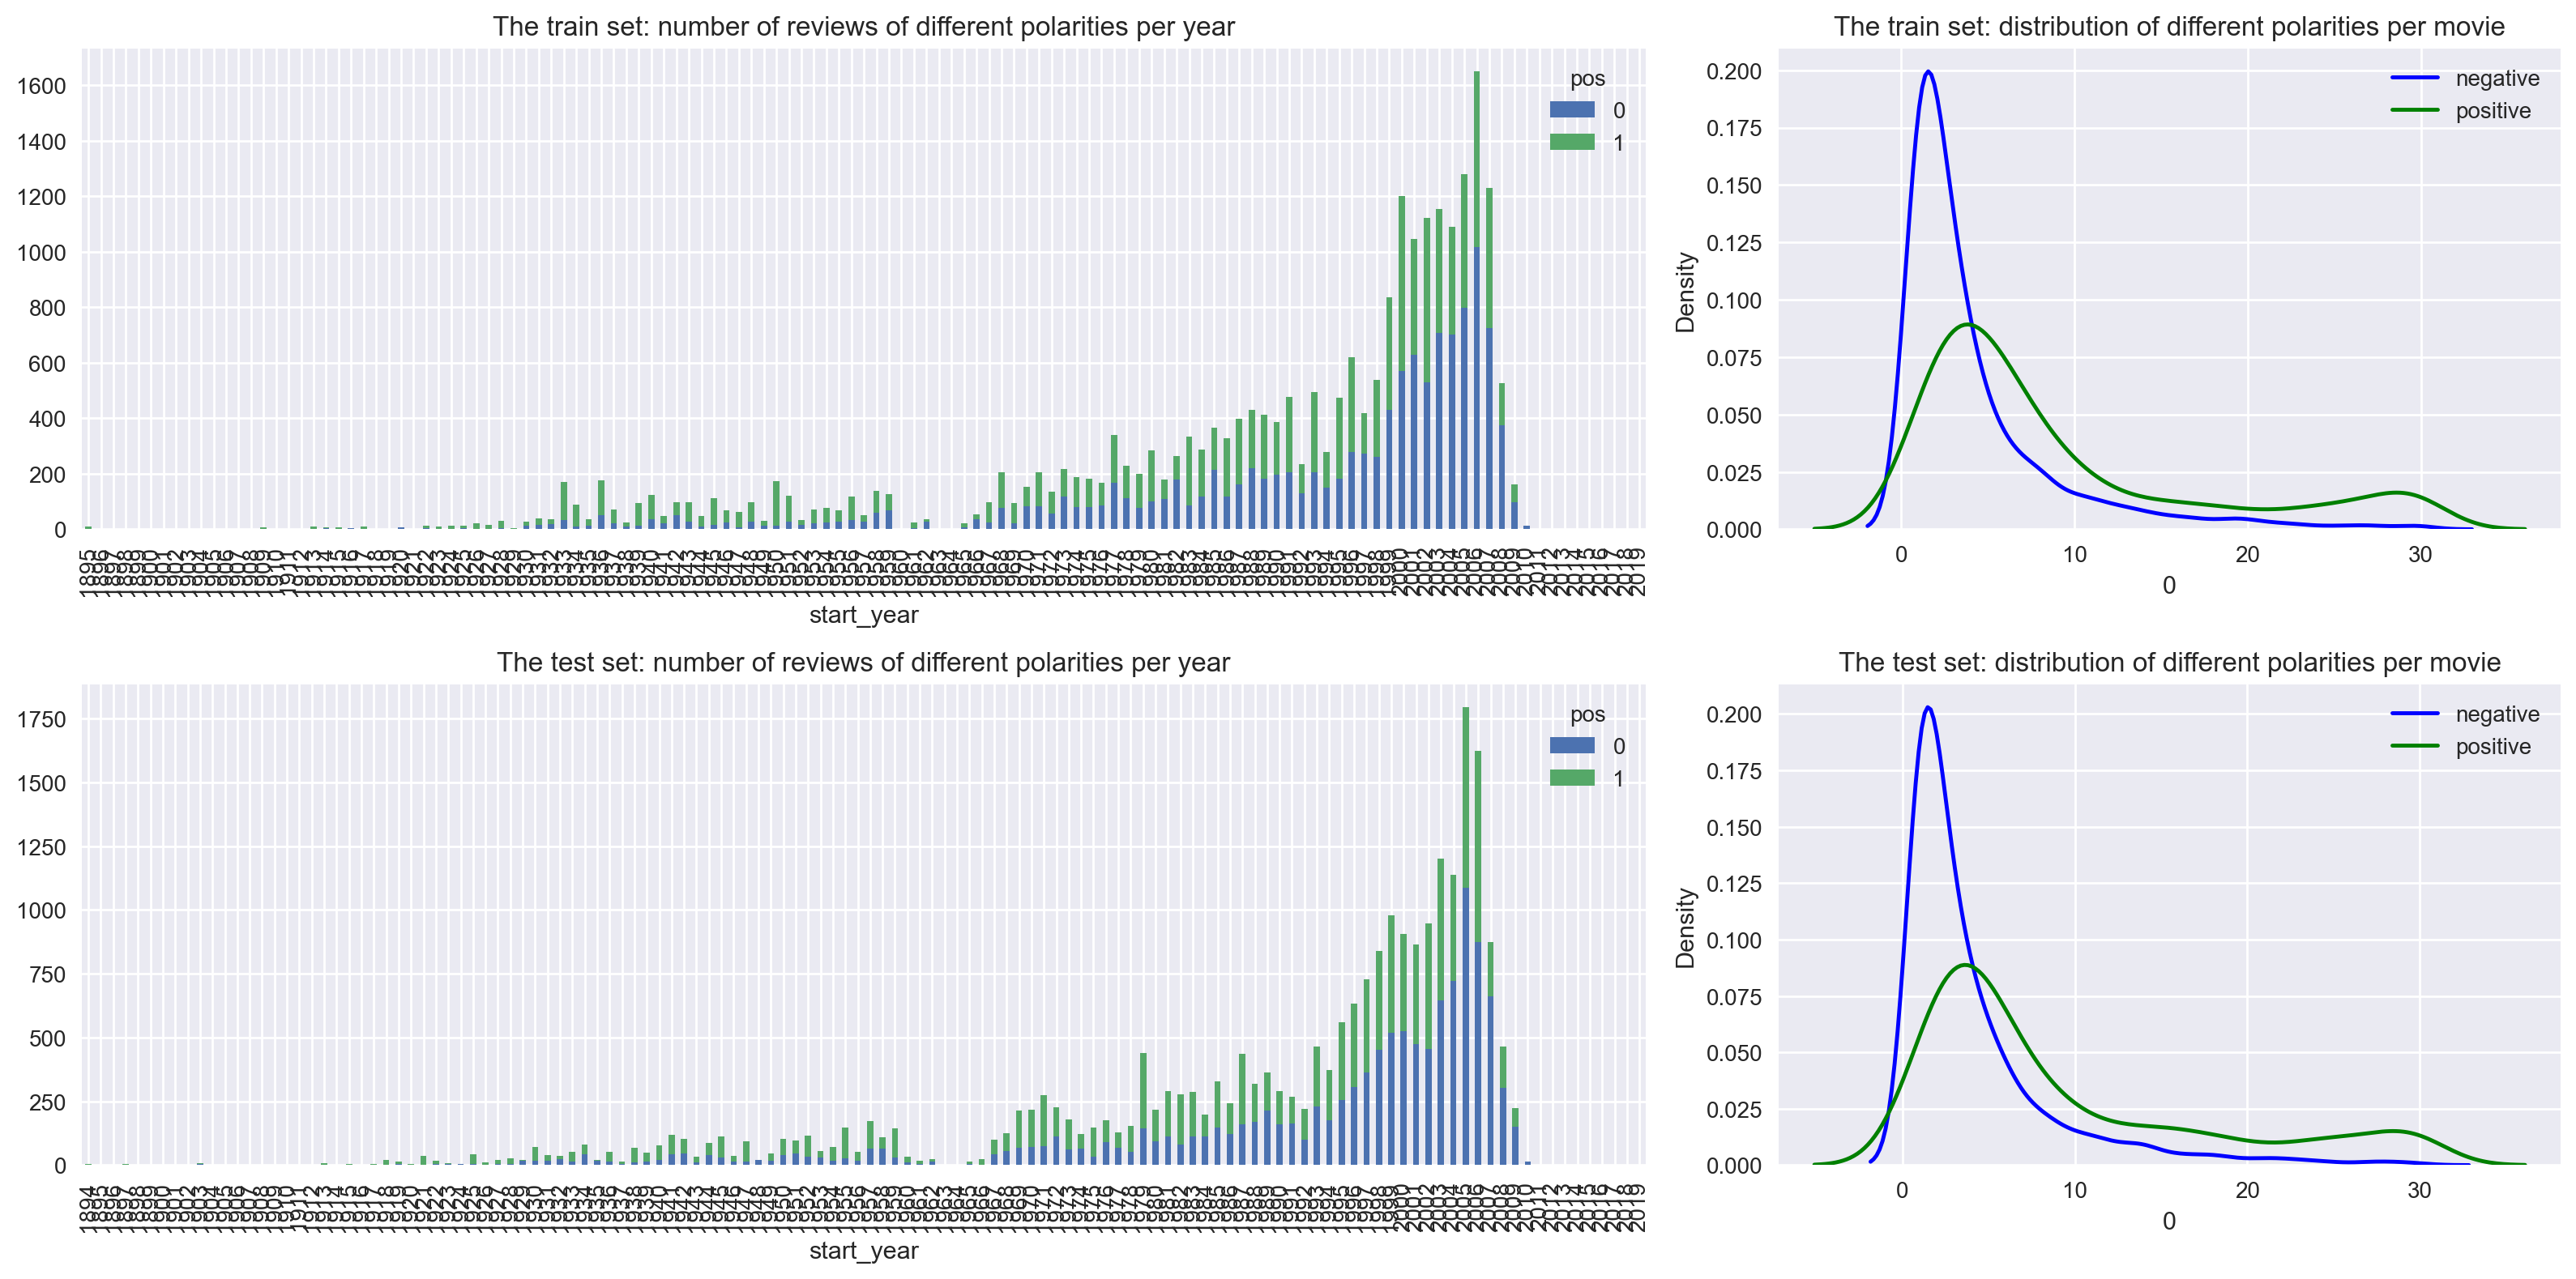

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [22]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [25]:
#preprocessing
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r"[^a-z\s']", '', regex=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47329 entries, 0 to 47328
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
 17  review_norm 

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [28]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Features and target

features_train = df_reviews_train['review_norm']
features_test = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

from sklearn.model_selection import train_test_split

# splitting the train data into train and validation data.

features_train_final, features_val, target_train_final, target_val = train_test_split(
    features_train, train_target, test_size=0.2, random_state=42)

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [31]:
from sklearn.dummy import DummyClassifier
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Downloads the stopwords list
nltk.download('stopwords') 
# Downloading the Punkt tokenizer
nltk.download('punkt') 

#Tokenization
df_reviews['review_norm'] = df_reviews['review_norm'].apply(word_tokenize)

# Removing stop words
stop_words = set(stopwords.words('english'))
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Joining tokens back into a string
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: ' '.join(x))

#Checking for empty reviews
df_reviews = df_reviews[df_reviews['review_norm'].str.strip().astype(bool)]

corpus = df_reviews['review_norm']

# Using TF-IDF vectorization

vectorizer = TfidfVectorizer(max_features=5000)

# Fitting and transforming the training data
features_train_tfidf = vectorizer.fit_transform(features_train_final)

# Transforming the validation and test data
features_val_tfidf = vectorizer.transform(features_val)
features_test_tfidf = vectorizer.transform(features_test)

# Initialize the DummyClassifier with the constant strategy
# Assuming '1' is the class we want to predict (e.g., positive reviews)
dummy_clf = DummyClassifier(strategy='constant', constant=1)

# Training the DummyClassifier on the training set
dummy_clf.fit(features_train_final, target_train_final)


# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
evaluate_model(dummy_clf, features_train_final, target_train_final, features_val, target_val)

# Evaluate the model on the test data
print("Evaluation on Test Data:")
evaluate_model(dummy_clf, features_test_tfidf, test_target, features_test_tfidf, test_target)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexkhol/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/alexkhol/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/Users/alexkhol/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


#### Dummyclassifier results in F1=0.67.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [ ]:

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model_1 = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
model_1.fit(features_train_tfidf, target_train_final)

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
evaluate_model(model_1, features_train_tfidf, target_train_final, features_val_tfidf, target_val)

# Evaluate the model on the test data
print("Evaluation on Test Data:")
evaluate_model(model_1, features_train_tfidf, target_train_final, features_test_tfidf, test_target)

#### Results: Model 1 - NLTK, TF-IDF and LR

##### Evaluation on Validation Data

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.91 |0.88  |
|F1              |0.91 |0.89  |
|APS             |0.97 |0.96  |
|ROC AUC         |0.97 |0.95  |

##### Evaluation on Test Data      

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.91 |0.88  |
|F1              |0.91 |0.88  |
|APS             |0.97 |0.95  |
|ROC AUC         |0.97 |0.95  |

### Model 2 - NLTK, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

# Initialize the LGBMClassifier model
lgbm_model = LGBMClassifier(random_state=42)

# Training the LGBMClassifier model on the training set
lgbm_model.fit(features_train_tfidf, target_train_final)

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
evaluate_model(lgbm_model, features_train_tfidf, target_train_final, features_val_tfidf, target_val)

# Evaluate the model on the test data
print("Evaluation on Test Data:")
evaluate_model(lgbm_model, features_test_tfidf, test_target, features_test_tfidf, test_target)

#### Results: Model 2 - NLTK, TF-IDF and LGBMClassifier

##### Evaluation on Validation Data

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.93 |0.86  |
|F1              |0.93 |0.86  |
|APS             |0.98 |0.94  |
|ROC AUC         |0.98 |0.94  |

##### Evaluation on Test Data      

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.86 |0.86  |
|F1              |0.86 |0.86  |
|APS             |0.93 |0.93  |
|ROC AUC         |0.94 |0.94  |


### Model 3 - spaCy, TF-IDF and LR

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:

# Preprocessing function
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc] 
    return ' '.join(tokens)

# Split data into train and test sets based on 'ds_part'
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Preprocess the 'review' column
df_reviews_train['review_norm'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['review_norm'] = df_reviews_test['review'].apply(text_preprocessing_3)

# Using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)

# Fitting and transforming the training data
features_train_tfidf = vectorizer.fit_transform(features_train_final)

# Transforming the validation and test data
features_val_tfidf = vectorizer.transform(features_val)
features_test_tfidf = vectorizer.transform(features_test)

# Initialize the Logistic Regression model
model_3 = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
model_3.fit(features_train_tfidf, target_train_final)

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
evaluate_model(model_3, features_train_tfidf, target_train_final, features_val_tfidf, target_val)

# Evaluate the model on the test data
print("Evaluation on Test Data:")
evaluate_model(model_3, features_train_tfidf, target_train_final, features_test_tfidf, test_target)


#### Results: Model 3 - spaCy, TF-IDF and LR

##### Evaluation on Validation Data

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.91 |0.88  |
|F1              |0.91 |0.89  |
|APS             |0.97 |0.95  |
|ROC AUC         |0.97 |0.95  |


##### Evaluation on Test Data      

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.91 |0.88  |
|F1              |0.91 |0.88  |
|APS             |0.97 |0.95  |
|ROC AUC         |0.97 |0.95  |

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

# Initialize the LGBMClassifier model
model_lgbm = LGBMClassifier(random_state=42)

# Train the model on the training data
model_lgbm.fit(features_train_tfidf, target_train_final)

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
evaluate_model(model_lgbm, features_train_tfidf, target_train_final, features_val_tfidf, target_val)

# Evaluate the model on the test data
print("Evaluation on Test Data:")
evaluate_model(model_lgbm, features_test_tfidf, test_target, features_val_tfidf, target_val)


#### Results: Model 4 - spaCy, TF-IDF and LGBMClassifier

##### Evaluation on Validation Data

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.93 |0.85  |
|F1              |0.93 |0.85  |
|APS             |0.98 |0.93  |
|ROC AUC         |0.98 |0.93  |


##### Evaluation on Test Data      

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.86 |0.85  |
|F1              |0.86 |0.85  |
|APS             |0.93 |0.93  |
|ROC AUC         |0.94 |0.93  |

### Model 5 - spaCy, TF-IDF and Random Forest Classifier

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier model
model_rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20], 
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2] 
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid,
                           scoring='f1', cv=3, n_jobs=-1, verbose=2)

# Train the model using Grid Search
grid_search.fit(features_train_tfidf, target_train_final)

# Get the best model from grid search
best_model_rf = grid_search.best_estimator_

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
evaluate_model(best_model_rf, features_train_tfidf, target_train_final, features_val_tfidf, target_val)

# Evaluate the model on the test data
print("Evaluation on Test Data:")
evaluate_model(best_model_rf, features_test_tfidf, test_target, features_val_tfidf, target_val)


#### Results: Model 5 - spaCy, TF-IDF and Random Forest Classifier

##### Evaluation on Validation Data

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.96 |0.84  |
|F1              |0.96 |0.84  |
|APS             |1.00 |0.91  |
|ROC AUC         |1.00 |0.91  |


##### Evaluation on Test Data      

| Metric         |train|test  |
|----------------|-----|------|
|Accuracy        |0.83 |0.84  |
|F1              |0.83 |0.84  |
|APS             |0.91 |0.91  |
|ROC AUC         |0.91 |0.91  |

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
'I was pleasantly surprised by this film! The storyline was engaging, and the characters felt real and relatable.',
'This film was a real disappointment. The plot was predictable, and the jokes fell flat. I expected more.',
'What a refreshing take on the genre! The creativity in the plot kept me on the edge of my seat. Definitely worth watching!',
'What a waste of talent! The actors seemed uninterested, and the script felt lazy and uninspired. I wouldn’t recommend it.',
'I was really looking forward to it, but it turned out to be a slog. The dialogue was cringeworthy, and the story went nowhere.',
'I absolutely loved the direction this movie took! The performances were strong, and the emotional depth really resonated with me.',
'This is exactly the kind of movie I have been looking for, it blended humor and drama perfectly.',
'Honestly, I didn’t enjoy it at all. The pacing was off, and I found myself checking my watch repeatedly.',
'I struggled to stay awake during this one. It was dull and dragged on without any real payoff.',
'This movie tried too hard to be clever but ended up being a confusing mess. I left feeling frustrated rather than entertained.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace(r"[^a-z\s']", '', regex=True)# <put here the same normalization logic as for the main dataset>

my_reviews

### Model 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm_model.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer
my_reviews_pred_prob = model_lgbm.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

In this project, we developed a sentiment analysis model to classify movie reviews as positive or negative using a dataset of IMDB reviews with polarity labels. The data was preprocessed by normalizing the 'review' column with case-lowering and the regex pattern r"[^a-z\s']", creating a 'review_norm' column. We then split the dataset into training and test sets using the 'gs_part' column, with an additional split of the training set into train and validation subsets.

To evaluate model performance, we used a pre-coded evaluation function. Initially, we trained and tested a constant-based Dummy Classifier, which resulted in an F1 score of 0.67, significantly below the target threshold of 0.85. We then used NLTK to tokenize, remove stopwords, and lemmatize the 'review_norm' values, followed by TF-IDF vectorization. Using the processed data, we trained Logistic Regression (F1=0.88) and LightGBM Classifier (F1=0.86), both of which yielded satisfactory results.

Additionally, we experimented with spaCy for tokenization and TF-IDF for vectorization, resulting in similar performances: Logistic Regression (F1=0.88), LightGBM Classifier (F1=0.86), and RandomForestClassifier (F1=0.84). While we also explored DecisionTreeClassifier and Support Vector Classifier (SVC) models, the hyperparameter tuning for these models led to excessively long training times, so we did not present their results. Finally, we applied the trained models to classify 10 new reviews as instructed.

Ultimately, the best models—Logistic Regression and LightGBM Classifier—achieved F1 scores above the target threshold, demonstrating effective performance for detecting negative movie reviews.


# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions